<a href="https://colab.research.google.com/github/trong-khanh-1109/CS114.L22.KHCL/blob/main/Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>BÀI TẬP COLAB SỐ 04</b></h1>
<h1 align="center"><b>Sarcasm detection in news headline</b></h1>

###LỚP: CS114.L21.KHCL-CS114.L22.KHCL
###NHÓM:
1. Đỗ Trọng Khánh - *19521676*
2. Võ Phạm Duy Đức - *19521383*
3. Trịnh Công Danh - *19521326*

#**I. Import thư viện cần thiết**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report

from keras import models, layers, optimizers, losses, callbacks

#**II. Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tin châm biếm
df_sarcasm_1 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/betoota.csv')
df_sarcasm_2 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/thehardtimes.csv')
df_sarcasm_3 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/thepoke.csv')
# Tin không châm biếm
df_not_sarcasm_1 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/citynews.csv')
df_not_sarcasm_2 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/fortune.csv')
df_not_sarcasm_3 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/thenewyork.csv')

In [ ]:
# Nối các file châm biếm thành 1 file
df_sarcasm = df_sarcasm_1.append(df_sarcasm_2, sort = True)
df_sarcasm = df_sarcasm.append(df_sarcasm_3, sort = True)
# Nối các file không châm biếm thành 1 file
df_not_sarcasm = df_not_sarcasm_1.append(df_not_sarcasm_2, sort = True)
df_not_sarcasm = df_not_sarcasm.append(df_not_sarcasm_3, sort = True)

In [ ]:
df = df_not_sarcasm.append(df_sarcasm, sort = True)
df

,article_link,headline,is_sarcastic
0,https://toronto.citynews.ca/2021/06/09/a-look-...,A look at COVID-19 vaccinations in Canada on W...,0
1,https://toronto.citynews.ca/2021/06/09/the-lat...,The latest numbers on COVID-19 in Canada for W...,0
2,https://toronto.citynews.ca/2021/06/09/b-c-app...,B.C. approves First Nations’ request to defer ...,0
3,https://toronto.citynews.ca/2021/06/09/northwe...,Northwest Territories launches reopening plan ...,0
4,https://toronto.citynews.ca/2021/06/09/report-...,Report says Canada needs to bolster plane cert...,0
...,...,...,...
12281,https://www.thepoke.co.uk/2018/05/02/best-camp...,Best campaign leaflet you’ll see this election,1
12282,https://www.thepoke.co.uk/2018/05/01/most-brut...,The most brutal ‘friend zoning’ of anyone you’...,1
12283,https://www.thepoke.co.uk/2018/05/01/someones-...,Someone’s collecting the most creative ways pe...,1
12284,https://www.thepoke.co.uk/2018/05/01/matthew-w...,Matthew Wright’s leaving The Wright Stuff so l...,1


In [ ]:
# Xáo trộn dữ liệu trong df
df = df.sample(frac=1).reset_index(drop=True)
df

,article_link,headline,is_sarcastic
0,https://fortune.com/2020/11/10/china-antitrust...,China’s clampdown on Internet industry has cos...,0
1,https://www.thepoke.co.uk/2019/10/11/the-types...,The types of colleagues you’ll usually find if...,1
2,https://thehardtimes.net/culture/trapt-issues-...,Trapt Issues “Start and Persist” Letter Urging...,1
3,https://thehardtimes.net/music/hardcore-singer...,Hardcore Singer Accidentally Swallows Microphone,1
4,https://toronto.citynews.ca/2021/04/01/how-can...,How Canada-China relations became strained to ...,0
...,...,...,...
41871,https://www.thepoke.co.uk/2019/12/10/11-of-the...,11 of the funniest (and occasionally most frig...,1
41872,https://www.thepoke.co.uk/2020/06/19/donald-tr...,Donald Trump just tweeted a faked CNN news vid...,1
41873,https://www.thepoke.co.uk/2019/12/09/donald-tr...,Donald Trump tried to mock Newsweek and it was...,1
41874,https://www.thepoke.co.uk/2019/12/17/people-ar...,People are enjoying the long – very long – lis...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41876 entries, 0 to 41875
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  41876 non-null  object
 1   headline      41876 non-null  object
 2   is_sarcastic  41876 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 981.6+ KB


#**III. Tiền xử lý dữ liệu**

In [ ]:
def get_sequences(texts, tokenizer, train = True, max_seq_length = None):
  sequences = tokenizer.texts_to_sequences(texts) # Ánh xạ mỗi từ của 1 câu qua số nguyên dương
  # Các câu đều có độ dài khác nhau nên bước tiếp theo chúng ta cần đưa chúng về cùng độ dài với độ dài là độ dài max của một chuỗi

  if train == True:
    max_seq_length = np.max(list(map(len, sequences)))  # Tìm chuỗi có độ dài lớn nhất
  sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_seq_length, padding = 'post') # Đưa các câu về cùng độ dài
  return sequences

In [ ]:
def preprocess_inputs(df):
  df = df.copy()
  # Xóa cột article_link
  df = df.drop('article_link', axis = 1)
  # 
  X = df['headline']
  y = df['is_sarcastic']
  # Chia tập dữ liệu train test
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1)
  # Tạo và fit tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(X_train)
  print("Số lượng từ (sắp xếp từ trên xuống dưới theo sự phổ biến)", len(tokenizer.word_index) + 1)
  # get sequences data
  X_train = get_sequences(texts = X_train, tokenizer = tokenizer, train = True)
  X_test = get_sequences(texts = X_test, tokenizer = tokenizer, train = False, max_seq_length = X_train.shape[1])
  print("Độ dài của câu: ", X_train.shape[1])
  return X_train, X_test, y_train, y_test

#**VI. Chia tập dữ liệu train test**

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

Số lượng từ (sắp xếp từ trên xuống dưới theo sự phổ biến) 28848
Độ dài của câu:  195


In [ ]:
X_train

array([[ 298,  217,   54, ...,    0,    0,    0],
       [1867,  844,    1, ...,    0,    0,    0],
       [ 108,   37,   96, ...,    0,    0,    0],
       ...,
       [ 706, 5735,  155, ...,    0,    0,    0],
       [ 115, 1072,   65, ...,    0,    0,    0],
       [ 122, 2445,    1, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_train.value_counts()

0    14977
1    14336
Name: is_sarcastic, dtype: int64

In [ ]:
X_test

array([[10412,  1642,  4878, ...,     0,     0,     0],
       [ 1158,  1937,   664, ...,     0,     0,     0],
       [  138,   636,     7, ...,     0,     0,     0],
       ...,
       [  239,  3911,   182, ...,     0,     0,     0],
       [    2,    42,    90, ...,     0,     0,     0],
       [   45,   679,  2485, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_test

1785     0
5104     0
8850     1
12585    0
15937    1
        ..
41451    0
31192    1
22860    0
32065    0
33359    0
Name: is_sarcastic, Length: 12563, dtype: int64

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train

array([[ 298,  217,   54, ...,    0,    0,    0],
       [1867,  844,    1, ...,    0,    0,    0],
       [ 108,   37,   96, ...,    0,    0,    0],
       ...,
       [ 706, 5735,  155, ...,    0,    0,    0],
       [ 115, 1072,   65, ...,    0,    0,    0],
       [ 122, 2445,    1, ...,    0,    0,    0]], dtype=int32)

#**V. Tạo model**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(28930, 16, input_length=40),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 16)            462880    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 465,185
Trainable params: 465,185
Non-trainable params: 0
_________________________________________________________________


#**VI. Training**

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=2)

Epoch 1/30
917/917 - 7s - loss: 0.4283 - accuracy: 0.7910 - val_loss: 0.1799 - val_accuracy: 0.9352
Epoch 2/30
917/917 - 6s - loss: 0.1352 - accuracy: 0.9504 - val_loss: 0.1161 - val_accuracy: 0.9563
Epoch 3/30
917/917 - 6s - loss: 0.0830 - accuracy: 0.9707 - val_loss: 0.0985 - val_accuracy: 0.9620
Epoch 4/30
917/917 - 6s - loss: 0.0566 - accuracy: 0.9813 - val_loss: 0.0933 - val_accuracy: 0.9643
Epoch 5/30
917/917 - 6s - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.0883 - val_accuracy: 0.9677
Epoch 6/30
917/917 - 6s - loss: 0.0279 - accuracy: 0.9917 - val_loss: 0.1142 - val_accuracy: 0.9575
Epoch 7/30
917/917 - 6s - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.1070 - val_accuracy: 0.9630
Epoch 8/30
917/917 - 6s - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.1006 - val_accuracy: 0.9673
Epoch 9/30
917/917 - 6s - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.1063 - val_accuracy: 0.9669
Epoch 10/30
917/917 - 6s - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.1178 - val_accuracy: 0.9647

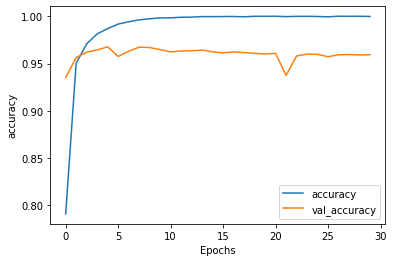

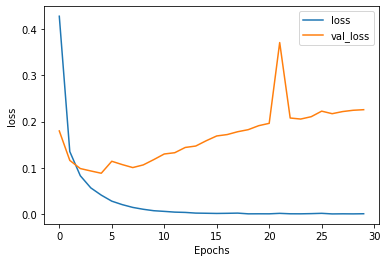

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Accuracy: 95.93%


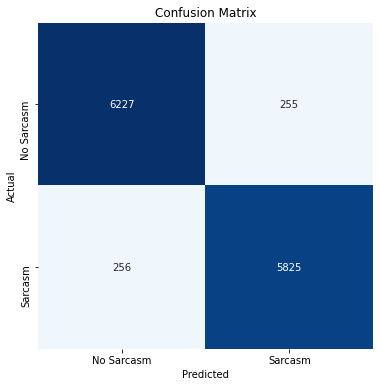

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.96      0.96      0.96      6482
     Sarcasm       0.96      0.96      0.96      6081

    accuracy                           0.96     12563
   macro avg       0.96      0.96      0.96     12563
weighted avg       0.96      0.96      0.96     12563



In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
#print(results)
print("Accuracy: {:.2f}%".format(results[1] * 100))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

#**VII. Dự đoán một tiêu đề bất kỳ**

In [ ]:
class_names = ['Not sarcastic', 'Sarcastic']


In [ ]:
headline = ["granny starting to fear spiders in the garden might be real"] 
print("Headline: ", headline)
print("\nTrue label: ", 1)
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=195, padding='post', truncating='post')

output = model.predict(headline)
pred = (output>0.5).astype('int64')

print("\nPredicted label: ", class_names[pred[0][0]])

Headline:  ['granny starting to fear spiders in the garden might be real']

True label:  1

Predicted label:  Sarcastic


#**VIII. Nhận xét:**
 - Theo biểu đồ ở mục VII ta thấy accuracy là rất cao (95.93%) nên model sử dụng cho bài toán này là tốt

#**IX. Tài liệu tham khảo**
- https://www.kaggle.com/gcdatkin/news-headline-sarcasm-detection
- https://cainvas.ai-tech.systems/use-cases/sarcasm-detection-app-for-news-headlines/#Visualization